In [8]:
import torch
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from getimagenetclasses import parseclasslabel, parsesynsetwords, get_classes
# Try other models https://pytorch.org/vision/stable/models.html
from torchvision.models import resnet18, ResNet18_Weights

In [9]:
class ImageNet2500(Dataset):
    def __init__(self, root_dir, xmllabeldir, synsetfile, images_dir, transform=None):

        """
    Args:

        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """

        self.root_dir = root_dir
        self.xmllabeldir = root_dir + xmllabeldir
        self.images_dir = root_dir + images_dir
        self.transform = transform
        self.imgfilenames = []
        self.labels = []
        self.ending = ".JPEG"

        indicestosynsets, self.synsetstoindices, synsetstoclassdescr = parsesynsetwords(root_dir + synsetfile)

        for file in os.listdir(self.images_dir):
            if file.endswith(".JPEG"):
                name = os.path.join(self.images_dir, file)
                self.imgfilenames.append(name)
                label, _ = parseclasslabel(self.filenametoxml(name), self.synsetstoindices)
                self.labels.append(label)

    def filenametoxml(self, fn):
        f = os.path.basename(fn)

        if not f.endswith(self.ending):
            print('not f.endswith(self.ending)')
            exit()

        f = f[:-len(self.ending)] + '.xml'
        f = os.path.join(self.xmllabeldir, f)

        return f

    def __len__(self):
        # todo: return the number of samples in the dataset
        return len(self.imgfilenames)

    def __getitem__(self, idx):
        # todo: load the image of index idx, transform it using the appropriate transforms 
        # and return it along with its label
        image = Image.open(self.imgfilenames[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
            image = self.transforms.ToTensor()(image)

        sample = {'image': image, 'label': label, 'filename': self.imgfilenames[idx]}

        return sample

In [10]:
def run_model(model, dataloader):
    pred = torch.Tensor()
    lbls = torch.Tensor()

    for batch_idx, data in enumerate(dataloader):
        prediction = model(data['image'])
        pred = torch.cat((pred, prediction), 0)
        lbls = torch.cat((lbls, data['label']), 0)
        if batch_idx == 8:
            break

    return pred, lbls


In [11]:
def plot_example(indx, model, dataset):
    sample = dataset[indx]
    plt.imshow(sample["image"].permute(1, 2, 0))
    plt.show()
    # im = transforms.ToPILImage()(sample["image"])
    # im.show()
    prediction = model(sample["image"].unsqueeze(0)).detach().numpy()[0]
    ind = prediction.argsort()[-5:][::-1]
    print("Top-5 predicted levels:\n")
    for key in ind:
        print(get_classes().get(key))

    print("\nTrue label ", get_classes()[sample["label"]])


In [12]:
def compare_performance(model, loader_wo_normalize, loader_w_normalize):
    # predictions and labels from dataset without normalization
    preds, labels = run_model(model, loader_wo_normalize)
    # predictions and labels from dataset with normalization (labels are the same as before)
    preds_norm, _ = run_model(model, loader_w_normalize)

    #  todo: calculate the accuracy when using normalized data and when using un-normalized data
    acc = None
    acc_norm = None

    print("Accuracy without normalize: ", acc)
    print("Accuracy with normalize: ", acc_norm)


In [13]:
main_path = "/mnt/e/ml_projects/IN3310/2025/exercise_data/week4_files/"
# These files/folders should be inside the main_path directory, i.e.
# ../solution /
# ├── ILSVRC2012_bbox_val_v3 /
# │   └── val /
# ├── imagenet2500 /
# │   └── imagespart /
# ├── getimagenetclasses.py
# └── synset_words.txt

xmllabeldir = "ILSVRC2012_bbox_val_v3/val/"
synsetfile = 'synset_words.txt'
images_dir = "imagenet2500/imagespart"

#  https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html
base_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

normalize_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#  todo: create a dataset and a dataloader without the normalization
dataset_wo_normalize = ImageNet2500(root_dir=main_path, 
                                    xmllabeldir=xmllabeldir, 
                                    synsetfile=synsetfile, 
                                    images_dir=images_dir, 
                                    transform=base_transform)
loader_wo_normalize = DataLoader(dataset_wo_normalize, batch_size=64, shuffle=False)

#  todo: create a dataset and a dataloader **with** normalization
dataset_w_normalize = ImageNet2500(root_dir=main_path, 
                                    xmllabeldir=xmllabeldir, 
                                    synsetfile=synsetfile, 
                                    images_dir=images_dir, 
                                    transform=normalize_transform)
loader_w_normalize = DataLoader(dataset_w_normalize, batch_size=64, shuffle=False)


In [14]:
# load a pretrained model of choice (see models in torchvision.models)
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# Set model to eval mode to use the learned-statistics instead of batch-statistics for batch_norm, and skip
# training-only operations like dropout. Try removing this line and see how the model performs!
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Accuracy without normalize:  None
Accuracy with normalize:  None


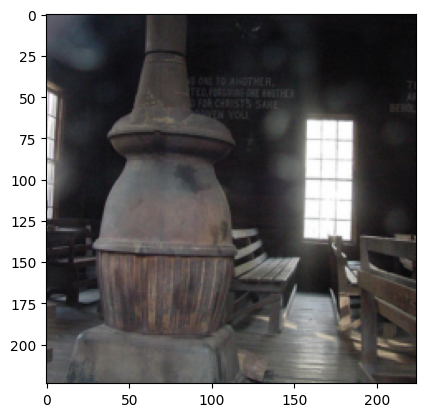

Top-5 predicted levels:

stupa, tope
beaker
pedestal, plinth, footstall
pickelhaube
syringe

True label  stove


In [15]:
compare_performance(model, loader_wo_normalize, loader_w_normalize)
# change the index to check other examples
plot_example(6, model, dataset_wo_normalize)